In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [20]:
def combine_calendar():
    calendar_df = pd.DataFrame()
    base_calendar = './data/calendar_'
    file_type = '.csv'
    cal = pd.read_csv(base_calendar + str(15) + file_type)
    cal['date'] = pd.to_datetime(cal['date'])
    cal = cal.sort_values(by=['date'], ascending = True)
    for i in range(14,0,-1):
        n_cal = pd.read_csv(base_calendar + str(i) + file_type)
        n_cal['date'] = pd.to_datetime(n_cal['date'])
        n_cal.sort_values(by=['date'])
        
        n_cal = pd.read_csv(base_calendar + str(i) + file_type)
        n_cal['date'] = pd.to_datetime(n_cal['date'])
        n_cal = n_cal.sort_values(by=['date'], ascending = True)
        
        cal_app = cal[cal.date < n_cal.iloc[0].date].copy()
        print('from_date: ' + cal.iloc[0].date.strftime("%m/%d/%Y") + ' to_date:' + n_cal.iloc[0].date.strftime("%m/%d/%Y"))
        cal_app.loc[cal_app.available=='t', ['available']] = float(1)
        cal_app.loc[cal_app.available=='f', ['available']] = float(0)
        cal_app.available = pd.to_numeric(cal_app.available, downcast='float')
        print('initial available')
            
        cal_app['price'] = cal_app['price'].map(lambda x: float(str(x).lstrip('$').replace(',','')))
        cal_app = cal_app.assign(week = lambda x: x['date'].dt.strftime('%W'))
        cal_app = cal_app.assign(year = lambda x: x['date'].dt.strftime('%Y'))
        cal_app['week'] = cal_app['week'].map(lambda x: int(x))
        cal_app['year'] = cal_app['year'].map(lambda x: int(x))
        
        cal_app = cal_app.groupby(['date', 'listing_id']).mean()
        cal_app = cal_app.assign(max_revenue = lambda x: x['price'] * x['available'] * 7)
        cal_app = cal_app.reset_index(level=[0,1])
        calendar_df = calendar_df.append(cal_app, ignore_index = True, sort=False)
        cal = n_cal
    return calendar_df

In [21]:
calendar_df = combine_calendar()
calendar_df = calendar_df.fillna(0)
calendar_df_gd_a = calendar_df.groupby(['date']).available.sum()
calendar_df_gd = calendar_df[calendar_df['available'] == 1].groupby(['date']).sum()
calendar_df_gd_p = calendar_df[calendar_df['available'] == 1].groupby(['date']).price.mean()

from_date: 04/18/2018 to_date:07/30/2018
initial available
from_date: 07/30/2018 to_date:08/21/2018
initial available
from_date: 08/21/2018 to_date:09/18/2018
initial available
from_date: 09/18/2018 to_date:10/17/2018
initial available
from_date: 10/17/2018 to_date:11/20/2018
initial available
from_date: 11/20/2018 to_date:12/18/2018
initial available
from_date: 12/18/2018 to_date:01/28/2019
initial available
from_date: 01/28/2019 to_date:02/17/2019
initial available
from_date: 02/17/2019 to_date:03/26/2019
initial available
from_date: 03/26/2019 to_date:04/24/2019
initial available
from_date: 04/24/2019 to_date:05/27/2019
initial available
from_date: 05/27/2019 to_date:06/28/2019
initial available
from_date: 06/28/2019 to_date:07/25/2019
initial available
from_date: 07/25/2019 to_date:08/31/2019
initial available


In [24]:
reviews_df = pd.read_csv('./data/reviews_sto.csv');
reviews_df['no_reviews'] = 1
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df_gd = reviews_df.groupby(['date']).agg({'no_reviews':'sum'})

In [25]:
rr = reviews_df_gd.reset_index(level=0, inplace=False)
pp = calendar_df_gd_p.reset_index(level=0, inplace=False)
xx = rr.merge(pp, on='date', how='inner')
xx = xx.set_index('date')
xx = xx.fillna(0)

(array([736785., 736815., 736846., 736876., 736907., 736938., 736968.,
        736999., 737029., 737060., 737091., 737119., 737150., 737180.,
        737211., 737241., 737272., 737303.]),
 <a list of 18 Text xticklabel objects>)

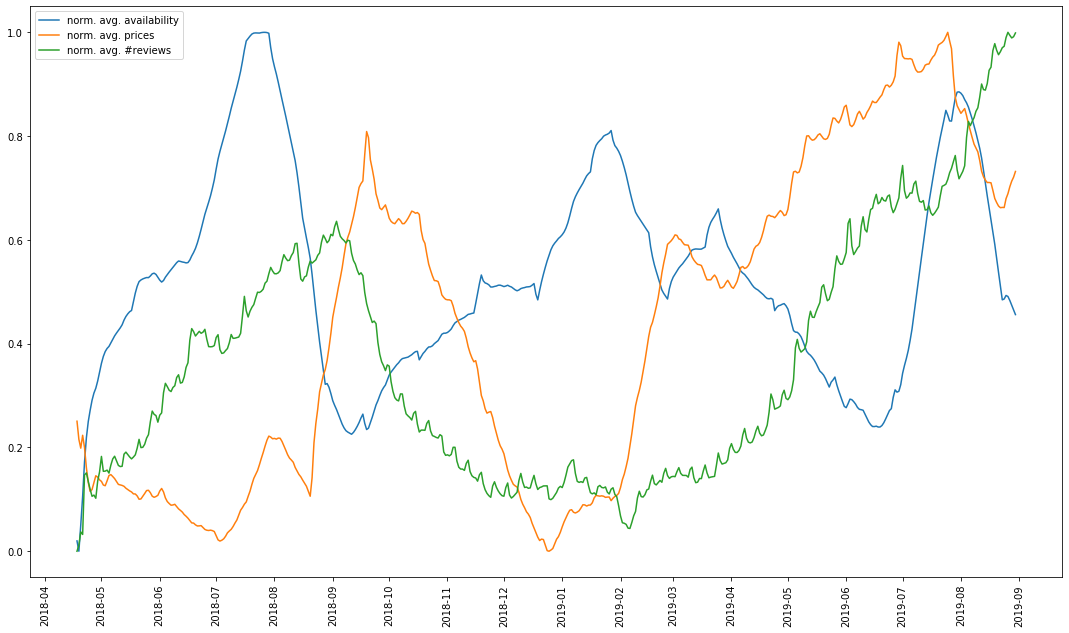

In [29]:
fig,ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)

y_mean = calendar_df_gd_a.rolling('30D').mean()
y_mean = (y_mean - min(y_mean))/(max(y_mean) - min(y_mean))
plt.plot(y_mean)

y_mean2 = calendar_df_gd_p.rolling('30D').mean()
y_mean2 = (y_mean2 - min(y_mean2))/(max(y_mean2) - min(y_mean2))
plt.plot(y_mean2)


y_mean3 = xx.no_reviews.rolling('30D').mean()
y_mean3 = (y_mean3 - min(y_mean3))/(max(y_mean3) - min(y_mean3))
plt.plot(y_mean3)
ax1.legend(['norm. avg. availability', 'norm. avg. prices', 'norm. avg. #reviews'])

monthyearFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(monthyearFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator([1,2,3,4,5,6,7,8,9,10,11,12])) 
plt.xticks(rotation=90)